In [1]:
import brightway2 as bw
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python
import csv
import stats_arrays
import scipy as sp
import pandas as pd
import pickle

In [2]:
bw.projects.set_current('4 param distrib')

In [3]:
bw.bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[#####                         ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 08/25/2017 09:02:08
  Finished: 08/25/2017 09:02:09
  Total time elapsed: 00:00:00
  CPU %: 99.60
  Memory %: 0.83
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 2.11 seconds
Wrote 718 LCIA methods with 178008 characterization factors
Creating core data migrations



# Creating new distribution: 4 parameter beta distribution

In [3]:
import numpy as np
from stats_arrays import *
from scipy import stats


class FourParamBetaUncertainty(UncertaintyBase):

    """
4 PARAM BETA DISTRIBUTIONS
The 4 parameters Beta distribution has the probability distribution function:

The :math:`\\alpha` parameter is ``loc``, and :math:`\\beta` is ``shape``. 
By default, the Beta distribution is defined from 0 to 1; the upper bound can be rescaled with the ``maximum`` parameter
and the lower bound with the ``minimum`` parameter.

Wikipedia: `Beta distribution <http://en.wikipedia.org/wiki/Beta_distribution>`_
    """
    id = 14
    description = "Four Parameters Beta uncertainty"

    @classmethod
    def validate(cls, params):
        scale_param=params['maximum']-params['minimum']
        if (params['loc'] > 0).sum() != params.shape[0]:
            raise InvalidParamsError("Real, positive alpha values are" +
                                     " required for Beta uncertainties.")
        if (params['shape'] > 0).sum() != params.shape[0]:
            raise InvalidParamsError("Real, positive beta values are" +
                                     " required for Beta uncertainties.")
        if (scale_param <= 0).sum():
            raise InvalidParamsError("Scale value must be positive or NaN")

    @classmethod
    def random_variables(cls, params, size, seeded_random=None,
                         transform=False):
        scale_param = params['maximum'] - params['minimum']
        if not seeded_random:
            seeded_random = np.random
        scale = scale_param
        scale[np.isnan(scale)] = 1
        return (params['minimum'].reshape((-1, 1)) + scale.reshape((-1, 1)) * 
                seeded_random.beta(params['loc'], params['shape'], size=(size,params.shape[0])).T)

    @classmethod
    def cdf(cls, params, vector):
        vector = cls.check_2d_inputs(params, vector)
        results = zeros(vector.shape)
        scale_param=params['maximum']-params['minimum']
        scale = scale_param
        scale[np.isnan(scale)] = 1
        for row in range(params.shape[0]):
            results[row, :] = stats.beta.cdf(vector[row, :],
                                             params['loc'][row], params['shape'][row],
                                             loc=params['minimum'][row],
                                             scale=scale[row])
        return results

    @classmethod
    def ppf(cls, params, percentages):
        percentages = cls.check_2d_inputs(params, percentages)
        results = zeros(percentages.shape)
        scale_param=params['maximum']-params['minimum']
        scale = scale_param
        scale[np.isnan(scale)] = 1
        for row in range(percentages.shape[0]):
            results[row, :] = stats.beta.ppf(percentages[row, :],
                                             params['loc'][row], params['shape'][row],
                                             loc=params['minimum'][row],
                                             scale=scale[row])
        return results

    @classmethod
    def statistics(cls, params):
        alpha = float(params['loc'])
        beta = float(params['shape'])
        mini = float(params['minimum'])
        maxi = float(params['maximum'])
        # scale = 1 if isnan(params['maximum'])[0] else float(params['maximum'])
        if alpha <= 1 or beta <= 1:
            mode = "Undefined"
        else:
            mode = mini + (maxi-mini) * (alpha - 1) / (alpha + beta - 2)
        return {
            'mean': mini + (maxi-mini) * alpha / (alpha + beta),
            'mode': mode,
            'median': "Not Implemented",
            'lower': mini,
            'upper': maxi
        }

    @classmethod
    def pdf(cls, params, xs=None):
        scale_param=params['maximum']-params['minimum']
        scale = 1 if np.isnan(scale_param)[0] else float(scale_param)
        if xs is None:
            xs = arange(0, scale, scale / cls.default_number_points_in_pdf)
        ys = stats.beta.pdf(xs, params['loc'], params['shape'],
                            loc=params['minimum'],
                            scale=scale)
        return xs, ys.reshape(ys.shape[1])

In [4]:
uncertainty_choices.add(FourParamBetaUncertainty)
print (FourParamBetaUncertainty in uncertainty_choices)

True


# Importing impact method with uncertain CF using 4 param beta distribution

In [6]:
input_filepath='methods_with_errors_ID14.55a38b3752c9c63824403cd0633fdcc8.bw2package'
ic_to_test=bw.BW2Package.import_file(input_filepath)

In [7]:
ic_names_to_test=[ic_name for ic_name in bw.methods if 'with uncert ID14' in str(ic_name) 
                  and '- only with spatial variability - Four param beta integration' not in str(ic_name)]
ic_names_to_test

[('IMPACTWorld+ - Endpoint - update august 15th 2017',
  'Ecosystem Quality',
  'Land transformation, biodiversity, GLO, with uncert ID14'),
 ('IMPACTWorld+ - Endpoint - update august 15th 2017',
  'Ecosystem Quality',
  'Land occupation, biodiversity, GLO, with uncert ID14'),
 ('IMPACTWorld+ - Endpoint - update august 15th 2017',
  'Ecosystem Quality',
  'Freshwater eutrophication, GLO, with uncert ID14')]

# Importing database containing one activity with all elementary flows in BW2

In [8]:
input_filepath='DB_For-test_v2.9536154a05725c74b8157d8b086f1aef.bw2package'
DB_test_list=bw.BW2Package.import_file(input_filepath)

Writing activities to SQLite3 database:
0%  100%
[#] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 08/25/2017 09:03:33
  Finished: 08/25/2017 09:03:34
  Total time elapsed: 00:00:00
  CPU %: 94.50
  Memory %: 1.13


# Monte Carlo calculation

In [5]:
#list_methods_name = IW_with_uncert
#fu_tuple = (act,1)
#iterations = 10

def MC_multi_impact(fu_tuple,list_methods_name,iterations):
    
    MC_results_dict={}
    fu_dict={fu_tuple[0]:fu_tuple[1]}
    
    for ic in list_methods_name:
        print(ic)
        MC_results_per_IC = bw.MonteCarloLCA(fu_dict,ic)
        scores = [next(MC_results_per_IC) for _ in range(iterations)]
        MC_results_dict[ic]=scores
    
    return MC_results_dict;

In [10]:
DB_test=bw.Database("For test_v2")
act=DB_test.get("All elementary flows")

list_methods_name = ic_names_to_test
fu_tuple = (act,1)
iterations = 10

scores=MC_multi_impact(fu_tuple,list_methods_name,iterations)
scores

('IMPACTWorld+ - Endpoint - update august 15th 2017', 'Ecosystem Quality', 'Land transformation, biodiversity, GLO, with uncert ID14')


MaximumIterationsError: 

In [11]:
%debug

> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/stats_arrays/distributions/base.py(212)bounded_random_variables()
    210             counter += 1
    211             if counter >= maximum_iterations:
--> 212                 raise MaximumIterationsError
    213         return data
    214 

ipdb> counter
50
ipdb> l
    207                                                      size, seeded_random)[bounds_mask]
    208             bounds_mask = (data < min_array) + (data > max_array)
    209 
    210             counter += 1
    211             if counter >= maximum_iterations:
--> 212                 raise MaximumIterationsError
    213         return data
    214 
    215     @classmethod
    216     def random_variables(cls, params, size, seeded_random=None):
    217         u"""Generate random variables for the given uncertainty. Should **not check** to ensure that random samples are with the (minimum, maximum bounds). Bounds checking is provided by the `bounded_random

ipdb> cls.random_variables(params, size, seeded_random).shape
(74, 74)
ipdb> data.shape
(74, 74)
ipdb> bounds_mask.shape
(74, 74)
ipdb> params.shape
(74,)
ipdb> size
1
ipdb> min_array.shape
(74, 1)
ipdb> min_array[:10, 0]
array([ 166.20359802,  -10.21539021,  -10.21539021,  -10.21539021,
          0.49329001,    0.49329001,    0.49329001,   32.0638504 ,
          0.        ,    8.31017971], dtype=float32)
ipdb> max_array[:10, 0]
array([ 183.70610046,  216.06468201,  216.06468201,  216.06468201,
         91.41197968,   91.41197968,   91.41197968,  315.78683472,
         62.46007538,   41.67506027], dtype=float32)
ipdb> cls.random_variables(params, size, seeded_random)[0, :10]
array([ 166.20359802,  -10.21539021,  -10.21539021,  -10.21539021,
          0.49329001,    0.49329001,    0.49329001,   32.0638504 ,
          0.        ,    8.31017971])
ipdb> cls.random_variables(params, size, seeded_random)[0, :10]
array([ 166.20359802,  -10.21539021,  -10.21539021,  -10.21539021,
          0.4

In [38]:
DB_test=bw.Database("For test_v2")
act=DB_test.get("All elementary flows")

list_methods_name = ic_names_to_test
fu_tuple = (act,1)
iterations = 10

MC_multi_impact(fu_tuple,list_methods_name,iterations)

('IMPACTWorld+ - Endpoint - update august 15th 2017', 'Ecosystem Quality', 'Land transformation, biodiversity, GLO, with uncert ID14')


MaximumIterationsError: 

In [39]:
%debug

> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/stats_arrays/distributions/base.py(212)bounded_random_variables()
    210             counter += 1
    211             if counter >= maximum_iterations:
--> 212                 raise MaximumIterationsError
    213         return data
    214 

ipdb> l 205
    200             # most restrictive bounds, as all the other bounds are satisfied
    201             # during iteration for the worst-case scenario. As this approach is
    202             # O(n), and the time for random number generation is << time for
    203             # solving the linear system, we don't try to find a clever way
    204             # around this inefficiency. See stats/tests/uncertainty.py -
    205             # UncertaintyTestCase - test_random_timing for a timing test.
    206             data[bounds_mask] = cls.random_variables(params,
    207                                                      size, seeded_random)[bounds_mask]
    208     

In [8]:
DB_test=bw.Database("For test_v2")
act=DB_test.get("All elementary flows")

list_methods_name = ic_names_to_test
fu_tuple = (act,1)
iterations = 10

MC_multi_impact(fu_tuple,list_methods_name,iterations)

('IMPACTWorld+ - Endpoint - update august 15th 2017', 'Ecosystem Quality', 'Land transformation, biodiversity, GLO, with uncert ID14')


ValueError: A and x have incompatible dimensions

In [9]:
%debug

> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/scipy/sparse/linalg/isolve/utils.py(112)make_system()
    110         x = array(x0, dtype=xtype)
    111         if not (x.shape == (N,1) or x.shape == (N,)):
--> 112             raise ValueError('A and x have incompatible dimensions')
    113         x = x.ravel()
    114 

ipdb> N
1
ipdb> x.shape
()
ipdb> x0.shape
()
ipdb> u
> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/scipy/sparse/linalg/isolve/iterative.py(272)cgs()
    270 @non_reentrant()
    271 def cgs(A, b, x0=None, tol=1e-5, maxiter=None, xtype=None, M=None, callback=None):
--> 272     A,M,x,b,postprocess = make_system(A,M,x0,b,xtype)
    273 
    274     n = len(b)

ipdb> type(A)
<class 'scipy.sparse.csr.csr_matrix'>
ipdb> A.shape
(1, 1)
ipdb> b.shape
*** The specified object '.shape' is not a function or was not found along sys.path.
ipdb> b
ipdb> b is None
*** The specified object 'is None' is not a function or was not found along sys.path.


ipdb> d
> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/scipy/sparse/linalg/isolve/iterative.py(272)cgs()
    270 @non_reentrant()
    271 def cgs(A, b, x0=None, tol=1e-5, maxiter=None, xtype=None, M=None, callback=None):
--> 272     A,M,x,b,postprocess = make_system(A,M,x0,b,xtype)
    273 
    274     n = len(b)

ipdb> !A
<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>
ipdb> !b
array([ 1.])
ipdb> x0
array(1.0)
ipdb> !b
array([ 1.])
ipdb> xtype
ipdb> d
> /Users/cmutel/miniconda3/envs/bw3/lib/python3.6/site-packages/scipy/sparse/linalg/isolve/utils.py(112)make_system()
    110         x = array(x0, dtype=xtype)
    111         if not (x.shape == (N,1) or x.shape == (N,)):
--> 112             raise ValueError('A and x have incompatible dimensions')
    113         x = x.ravel()
    114 

ipdb> x
array(1.0)
ipdb> x.shape
()
ipdb> N
1
ipdb> q


In [41]:
stats_arrays.BetaUncertainty.random_variables(params, 10).shape

(1, 10)

In [42]:
FourParamBetaUncertainty.random_variables(params, 10).shape

(1, 10)

In [50]:
params_multi = FourParamBetaUncertainty.from_dicts(*[x[1] for x in cfs[:4]])
stats_arrays.BetaUncertainty.random_variables(FourParamBetaUncertainty.from_dicts(*[x[1] for x in cfs[:4]]), 10).shape

(4, 10)

In [54]:
FourParamBetaUncertainty.random_variables(params_multi, 10).shape

(4, 10)

In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
cfs = bw.Method(('IMPACTWorld+ - Endpoint - update august 15th 2017', 
                 'Ecosystem Quality', 
                 'Land transformation, biodiversity, GLO, with uncert ID14')).load()
cfs[:5]

[(('biosphere3', '99127c79-69f5-4046-a298-3f842c68d62b'),
  {'amount': -168.8913863,
   'loc': 1.0337e-14,
   'maximum': -166.2035984,
   'minimum': -183.7061033,
   'shape': 1.87542e-15,
   'uncertainty type': 14,
   'uncertainty_type': 14}),
 (('biosphere3', 'e97b784a-ec09-4b1b-9f14-cc0ce9799c9e'),
  {'amount': 159.166675,
   'loc': 0.057658156,
   'maximum': 315.786837,
   'minimum': 32.06385025,
   'shape': 0.071048222,
   'uncertainty type': 14,
   'uncertainty_type': 14}),
 (('biosphere3', '00d15dd1-8517-49dd-933d-e7db77e9d342'),
  {'amount': -22.63665981,
   'loc': 5.06805e-16,
   'maximum': -8.310179922,
   'minimum': -41.67505986,
   'shape': 3.81373e-16,
   'uncertainty type': 14,
   'uncertainty_type': 14}),
 (('biosphere3', '99801a43-d476-4055-8d97-fb7c4ae173d4'),
  {'amount': -37.34469997,
   'loc': 0.27636933,
   'maximum': -0.493290004,
   'minimum': -91.41197914,
   'shape': 0.188369003,
   'uncertainty type': 14,
   'uncertainty_type': 14}),
 (('biosphere3', '4e1715ba-

In [27]:
params = FourParamBetaUncertainty.from_dicts(cfs[0][1])
FourParamBetaUncertainty.random_variables(params, 100)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

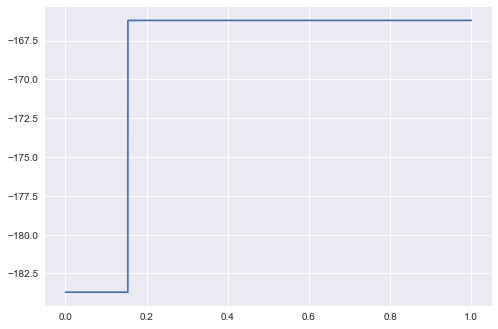

In [35]:
xs = np.linspace(0, 1, 100000)
ys = FourParamBetaUncertainty.ppf(params, xs.reshape(1, -1)).ravel()
plt.plot(xs, ys)

## Check bounds reasonableness

In [51]:
def bound_uncertainty_valid_or_not(cf):
    
    uncert=stats_arrays.UncertaintyBase.from_dicts(cf[1])
    
    try:
        FourParamBetaUncertainty.check_bounds_reasonableness(uncert)
        valid_or_not='ok'
        
    except UnreasonableBoundsError:
        valid_or_not='UnreasonableBoundsError'

    return valid_or_not;

In [52]:
valid_or_not={}
error_to_follow=stats_arrays.UnreasonableBoundsError

for ic_name in ic_names_to_test:
    ic=bw.Method(ic_name)
    
    valid_or_not[ic_name]=[]
    
    for cf in ic.load():
        if type(cf[1])==dict:
            test_cf=bound_uncertainty_valid_or_not(cf)
            valid_or_not[ic_name].append((cf[0][1],test_cf))
        
valid_or_not

{('IMPACTWorld+ - Endpoint - update august 15th 2017',
  'Ecosystem Quality',
  'Freshwater eutrophication, GLO, with uncert ID14'): [('fc0b5c85-3b49-42c2-a3fd-db7e57b696e3',
   'ok'),
  ('4ab486b5-7102-4a88-a7fd-3e7b42e0e2e2', 'ok'),
  ('503ccbc4-8697-46e7-9a9b-beee17d4cdec', 'ok'),
  ('4574cd53-77cc-4540-827b-5736dda9c4d7', 'ok'),
  ('b3cfad3f-b7da-490b-a491-8507a1bb7c4b', 'ok'),
  ('b2631209-8374-431e-b7d5-56c96c6b6d79', 'ok'),
  ('2d4b8ec1-8d53-4e62-8a11-ebc45909b02e', 'ok'),
  ('7ae398c8-8532-11e0-9d78-0800200c9a66', 'ok'),
  ('1727b41d-377e-43cd-bc01-9eaba946eccb', 'ok'),
  ('2a89246a-8408-4775-a6db-7c33656f1469', 'ok'),
  ('4a5a08f6-51ab-41e7-809a-13d70b509740', 'ok'),
  ('8d33cd5f-c365-44b8-bb70-a211d5bb15dd', 'ok'),
  ('b2c8d9ab-da12-445f-bf52-eeca64a96fd6', 'ok'),
  ('ad62c648-1af8-4805-bbfb-64c6361eb9f6', 'ok'),
  ('a87680bc-ecde-471a-88bb-6bc7482a62cf', 'ok'),
  ('c8791f3c-3c4a-4278-91c0-483797d14da2', 'ok'),
  ('7ea403ad-aba6-4f89-843f-41266477064f', 'ok'),
  ('6a7e5863-71